In [1]:
from functools import partial
from itertools import product
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr
from sklearn.pipeline import Pipeline
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import SoilsDataset
from umap import UMAP
from scipy.spatial.distance import cdist
from skbio.stats.distance import bioenv, DistanceMatrix


In [2]:
soils_data = SoilsDataset('data/soils')
tree = soils_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [3]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)

soil_mf = soils_data['metadata']
soil_table = soils_data['table']
metadata = soil_mf.set_index('sample_name')
soil_table = soil_table.filter(metadata.index)
table = min_count_filter.fit_transform(soil_table)
metadata = metadata.loc[table.ids('sample')]

In [4]:
metadata.columns

Index(['annual_season_precpt', 'annual_season_temp', 'anonymized_name',
       'carb_nitro_ratio', 'cmin_rate', 'collection_date', 'country', 'depth',
       'description', 'dna_extracted', 'elevation', 'env_biome', 'env_feature',
       'host_subject_id', 'latitude', 'longitude', 'ph',
       'physical_specimen_remaining', 'project_name', 'public',
       'qiita_study_id', 'sample_type', 'silt_clay', 'soil_moisture_deficit',
       'soil_type', 'specific_location', 'texture', 'title', 'tot_org_carb',
       'tot_org_nitro'],
      dtype='object')

In [5]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [6]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [7]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

In [8]:
clr_table = aitchison_pipeline.fit_transform(table)
dm = DistanceMatrix(cdist(clr_table, clr_table), ids=table.ids())

In [9]:
numeric_metadata = metadata.select_dtypes(include=['number'])
nunique = numeric_metadata.apply(pd.Series.nunique)
cols_to_drop = nunique.loc[nunique <= 1].index
numeric_metadata = numeric_metadata.drop(cols_to_drop, axis=1)

In [10]:
bioenv(dm, numeric_metadata)

,size,correlation
vars,,
ph,1,0.649058
"annual_season_temp, ph",2,0.609095
"annual_season_temp, ph, soil_moisture_deficit",3,0.583832
"annual_season_temp, ph, silt_clay, soil_moisture_deficit",4,0.556881
"annual_season_temp, elevation, ph, silt_clay, soil_moisture_deficit",5,0.523176
"annual_season_temp, carb_nitro_ratio, elevation, ph, silt_clay, soil_moisture_deficit",6,0.507375
"annual_season_temp, carb_nitro_ratio, elevation, longitude, ph, silt_clay, soil_moisture_deficit",7,0.497440
"annual_season_temp, carb_nitro_ratio, cmin_rate, elevation, longitude, ph, silt_clay, soil_moisture_deficit",8,0.482863
"annual_season_temp, carb_nitro_ratio, elevation, longitude, ph, silt_clay, soil_moisture_deficit, tot_org_carb, tot_org_nitro",9,0.469614


In [11]:
bioenv(dm, numeric_metadata, columns=['ph']).correlation[0]

0.6490579336229719

In [12]:
bioenv_results = []
for column in numeric_metadata.columns:
    bioenv_correlation = bioenv(
        dm,
        numeric_metadata,
        columns=[column],
    ).correlation[0]
    bioenv_results.append({
        'var': column,
        'correlation': bioenv_correlation,
    })

In [13]:
pd.DataFrame(
    bioenv_results
).sort_values('correlation', ascending=False)

,var,correlation
7,ph,0.649058
9,soil_moisture_deficit,0.310174
6,longitude,0.273809
0,annual_season_precpt,0.266444
5,latitude,0.194024
1,annual_season_temp,0.178104
11,tot_org_nitro,0.165773
10,tot_org_carb,0.137546
8,silt_clay,0.119703
2,carb_nitro_ratio,0.115390


In [14]:
def UmapPCA(metric, min_dist=0.15, n_neighbors=15, random_state=None,
            n_components=2):
    return Pipeline([
        ('umap', UMAP(metric=metric,
                      min_dist=min_dist,
                      n_neighbors=n_neighbors,
                      n_components=n_components,
                      random_state=random_state,
                      )),
        ('pca', PCA()),
    ])

In [15]:
def pcoa_amend_axes(transformer, axes_names):
    pe = transformer.ordination_.proportion_explained
    return [f'{axn} ({pexp:.1%})' for pexp, axn in zip(pe, axes_names)]

In [16]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
        'axes': ['PCoA-1', 'PCoA-2'],
        'amend_axes': pcoa_amend_axes,
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            n_neighbors=80,
            random_state=825,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2'],
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(
            UmapPCA,
            min_dist=1.0,
            random_state=724,
            n_components=2,
        ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2'],
    },
]

In [17]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    amend_axes = emb.get('amend_axes', lambda t, labels: labels)
    results[(name, method)] = {'ordination': result,
                               'axes': amend_axes(transformer, emb['axes']),
                               }


In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns


In [19]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}


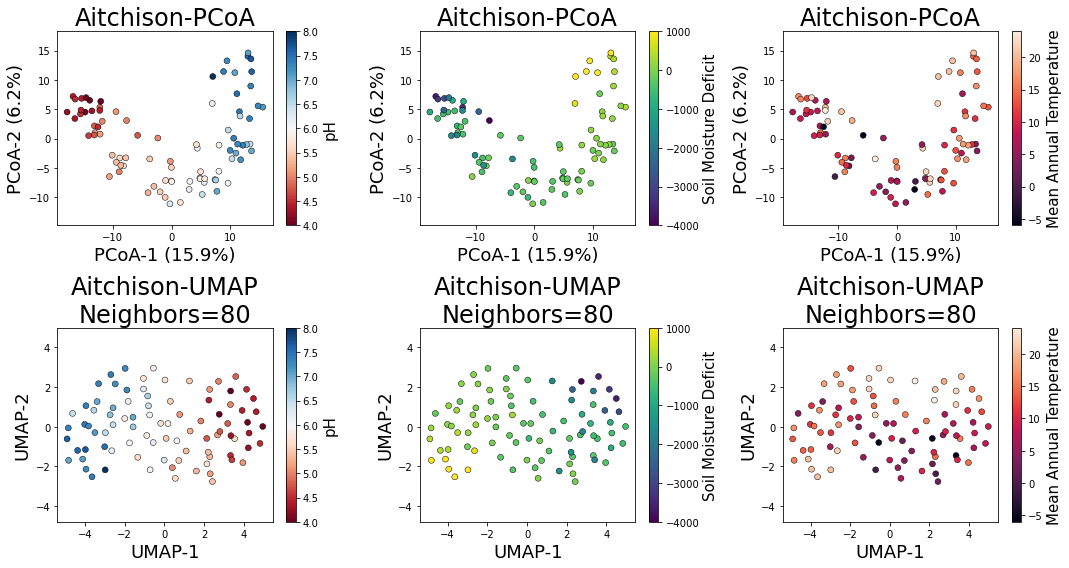

In [20]:
class AxesWrapper:

    def __init__(self, nrows, ncols, axs, transpose=False):
        self.axs = axs
        self.nrows = nrows
        self.ncols = ncols
        self.transpose = transpose

    def __getitem__(self, pos):
        x, y = pos
        if self.nrows == 1 and self.ncols == 1:
            return self.axs
        elif self.nrows == 1:
            return self.axs[x]
        elif self.ncols == 1:
            return self.axs[y]
        elif self.transpose:
            return self.axs[y][x]
        else:
            return self.axs[x][y]


def subplots_wrapper(nrows, ncols, *args, transpose=False, **kwargs):
    fig, axs = plt.subplots(nrows, ncols, *args, **kwargs)
    return fig, AxesWrapper(nrows, ncols, axs, transpose=transpose)

fig, axs = subplots_wrapper(2, 3,
                            figsize=(15, 8),
                            transpose=True,
                            )
hue_var = 'ph'
cs1 = "RdBu"
hue2 = 'soil_moisture_deficit'
cs2 = "viridis"
hue3 = 'annual_season_temp'
cs3 = "rocket"
POINT_SIZE = 35

keep_keys = {
    ('Aitchison', 'PCoA'),
    ('Aitchison', 'UMAP\nNeighbors=80'),
}

filtered_results = {key: val for key, val in results.items() if key in
                    keep_keys}
for (name, method), result in filtered_results.items():
        j = h_position_map[method]
        res = result['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        norm = mpl.colors.Normalize(vmin=4, vmax=8)
        cmap = sns.color_palette(cs1, as_cmap=True)
        ph_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue_var,
            data=res,
            ax=axs[[0, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs1,
            cmap=ph_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(ph_mapper, ax=g)
        cbar.ax.set_ylabel('pH', fontsize=15)

        norm = mpl.colors.Normalize(vmin=-4000, vmax=1000)
        cmap = sns.color_palette(cs2, as_cmap=True)
        temp_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue2,
            data=res,
            ax=axs[[1, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs2,
            cmap=temp_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)
        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(temp_mapper, ax=g)
        cbar.ax.set_ylabel('Soil Moisture Deficit', fontsize=15)


        norm = mpl.colors.Normalize(vmin=-6, vmax=24)
        cmap = sns.color_palette(cs3, as_cmap=True)
        temp_mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue=hue3,
            data=res,
            ax=axs[[2, j]],
            s=POINT_SIZE,
            edgecolor='k',
            palette=cs3,
            cmap=temp_mapper,
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)
        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18),
        cbar = fig.colorbar(temp_mapper, ax=g)
        cbar.ax.set_ylabel('Mean Annual Temperature', fontsize=15)


plt.tight_layout()
plt.savefig(f'results/2.0-real-data-soil-ordination-Aitchison-{hue_var}-{hue2}'
            f'-{hue3}.svg')
plt.show()

In [21]:

def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import CCA, PLSCanonical
from scipy.spatial.distance import cdist
import numpy as np


In [44]:
target_var = 'ph'
class mock_result:
    correlation = 0

    def __getitem__(self, item):
        return 0

all_correlations = []
for (name, method), result in results.items():
    target = metadata[target_var]

    first_component = result['ordination']['PC1']
    for category in metadata.columns:
        target = metadata[category]
        sr2 = spearmanr(target, first_component)
        all_correlations.append({
            'name': name,
            'PC': 1,
            'method': method,
            'category': category,
            'spearmanr': sr2.correlation,
            'p-value': sr2[1],
        })

    second_component = result['ordination']['PC2']

    secondary_gradients = [None, mock_result()]
    for category in metadata.columns:
        secondary_target = metadata[category]
        if np.issubdtype(secondary_target, np.number):
            sr2 = pearsonr(secondary_target, second_component)
            all_correlations.append({
                'name': name,
                'method': method,
                'PC': 2,
                'category': category,
                'spearmanr': sr2[0],
                'p-value': sr2[1],
            })
            if abs(sr2[0]) > abs(secondary_gradients[1][0]):
                secondary_gradients = [category, sr2]

    # print(name, method, spearmanr(target, first_component))
    # print(name, method, secondary_gradients)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [45]:
corr_df = pd.DataFrame(all_correlations).query(
    "("
    "name == 'Aitchison' "
    " and "
    "("
    "(category == 'annual_season_temp') "
    "or (category == 'ph'))"
    "or (category == 'soil_moisture_deficit')"
    ")"
    " and (method != 'UMAP\\nNeighbors=15')"
    ""
).sort_values(by=['category', 'PC'])

corr_df['spearmanr'] = corr_df['spearmanr'].round(3)

corr_df['method'] = corr_df['method'].str.replace('\n', ' ')

In [46]:
corr_df

,name,PC,method,category,spearmanr,p-value
1,Aitchison,1,PCoA,annual_season_temp,0.173,1.065143e-01
45,Aitchison,1,UMAP Neighbors=80,annual_season_temp,-0.184,8.546464e-02
31,Aitchison,2,PCoA,annual_season_temp,0.313,2.998123e-03
75,Aitchison,2,UMAP Neighbors=80,annual_season_temp,0.478,2.467961e-06
16,Aitchison,1,PCoA,ph,0.934,2.872925e-40
60,Aitchison,1,UMAP Neighbors=80,ph,-0.931,2.434330e-39
38,Aitchison,2,PCoA,ph,0.104,3.330142e-01
82,Aitchison,2,UMAP Neighbors=80,ph,-0.009,9.302657e-01
23,Aitchison,1,PCoA,soil_moisture_deficit,0.828,2.759770e-23
67,Aitchison,1,UMAP Neighbors=80,soil_moisture_deficit,-0.848,2.194002e-25
